In [1]:
import os
import numpy as np
import pandas as pd
from itertools import groupby
from astropy.io import fits

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod


MASTERS_DIR = os.getenv("LVM_MASTER_DIR")

# define target folder for detrended darks
target_dir = "data_pixmask"
os.makedirs(target_dir, exist_ok=True)

## Darks processing

We perform the following steps with darks:

- fetch darks metadata from MJD=60146
- preprocess darks
- detrend darks using the corresponding master bias
- combine master darks by camera and exposure time

We should end up with two sets of master darks, one set for each exposure time

In [2]:
MJD = 60146
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(MASTERS_DIR, f"{masters_mjd}")
print(f"using master calibration frames in: {masters_path}")

# define short/long exposure times
short_exptime = 900
long_exptime = 3600

# get darks metadata
darks = md.get_metadata(kind="raw", tileid="*", mjd=MJD, imagetyp="dark")
darks.query("exptime == @short_exptime | exptime == @long_exptime", inplace=True)
darks

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60146/raw_metadata.hdf5
[INFO]: found 747 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60146/raw_metadata.hdf5'
[INFO]: filtering by imagetyp = 'dark'
[INFO]: number of frames after filtering 144
[INFO]: total number of frames found 144


using master calibration frames in: /home/mejia/Research/lvm/lvmdata/calib/60142


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
1,s,1111,60146,60146,dark,sp1,b1,1496,3600.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00001496.fits
2,s,1111,60146,60146,dark,sp1,z1,1495,3600.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z1-00001495.fits
3,s,1111,60146,60146,dark,sp2,r2,1497,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001497.fits
6,s,1111,60146,60146,dark,sp2,r2,1501,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001501.fits
7,s,1111,60146,60146,dark,sp3,z3,1497,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00001497.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,s,1111,60146,60146,dark,sp2,r2,1500,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001500.fits
134,s,1111,60146,60146,dark,sp3,r3,1457,900.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r3-00001457.fits
135,s,1111,60146,60146,dark,sp3,z3,1456,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00001456.fits
136,s,1111,60146,60146,dark,sp2,z2,1500,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00001500.fits


In [3]:
ddark_paths = []
for dark in darks.to_dict("records"):
    dark_path = path.full("lvm_raw", camspec=dark["camera"], **dark)
    # print(dark_path)
    
    # output path
    cam = dark["camera"]
    exp = dark["expnum"]
    ddark_path = os.path.join(target_dir, f"lvm-ddark-{cam}-{exp:>08d}.fits")
    ddark_paths.append(ddark_path)

    if os.path.isfile(ddark_path):
        print(f"skipping {ddark_path}, file already exist")
        continue
    
    # calib paths
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{cam}.fits")
    
    imageMethod.preproc_raw_frame(in_image=dark_path, out_image=ddark_path, replace_with_nan=False)
    imageMethod.detrend_frame(in_image=ddark_path, out_image=ddark_path, in_bias=mbias_path, convert_to_e=True, reject_cr=False, replace_with_nan=False)

skipping data_pixmask/lvm-ddark-b1-00001496.fits, file already exist
skipping data_pixmask/lvm-ddark-z1-00001495.fits, file already exist
skipping data_pixmask/lvm-ddark-r2-00001497.fits, file already exist
skipping data_pixmask/lvm-ddark-r2-00001501.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001497.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001496.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001457.fits, file already exist
skipping data_pixmask/lvm-ddark-z2-00001499.fits, file already exist
skipping data_pixmask/lvm-ddark-r3-00001499.fits, file already exist
skipping data_pixmask/lvm-ddark-b2-00001495.fits, file already exist
skipping data_pixmask/lvm-ddark-b2-00001500.fits, file already exist
skipping data_pixmask/lvm-ddark-b2-00001497.fits, file already exist
skipping data_pixmask/lvm-ddark-b2-00001494.fits, file already exist
skipping data_pixmask/lvm-ddark-r2-00001498.fits, file already exist
skipping data_pixmask/lvm-ddark-b2

In [4]:
darks["ddark_path"] = ddark_paths
cam_groups = darks.groupby(["camera", "exptime"])
for cam, exptime in cam_groups.groups:
    ddark_paths_cam = cam_groups.get_group((cam, exptime))["ddark_path"]
    
    # define output combined dark path
    mdark_path = os.path.join(target_dir, f"lvm-mdark-{cam}-{int(exptime)}s.fits")
    if os.path.isfile(mdark_path):
        print(f"skipping {mdark_path}, file already exist")
        continue
    
    imageMethod.create_master_frame(in_images=ddark_paths_cam, out_image=mdark_path)

skipping data_pixmask/lvm-mdark-b1-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b1-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-b2-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b2-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-b3-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b3-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-r1-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-r1-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-r2-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-r2-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-r3-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-r3-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-z1-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-z1-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-z2-900s.fits, file already exist
skipping data_pixm

## Pixelflats processing

We perform the following steps with pixelflats:

- fetch *darks* metadata from MJD=60171
- preprocess darks, setting `imagetyp='pixelflat'`
- detrend darks using the corresponding master bias
- combine master darks by camera and exposure time

We should end up with two sets of master darks, one set for each exposure time

In [5]:
MJD = 60171
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(MASTERS_DIR, f"{masters_mjd}")
print(f"using master calibration frames in: {masters_path}")

# get darks metadata
pixflats = md.get_metadata(kind="raw", tileid="*", mjd=MJD, imagetyp="dark")
pixflats = pixflats.loc[pixflats.expnum.isin(range(3098, 3117+1))]
pixflats

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5


using master calibration frames in: /home/mejia/Research/lvm/lvmdata/calib/60142


[INFO]: found 756 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5'
[INFO]: filtering by imagetyp = 'dark'
[INFO]: number of frames after filtering 288
[INFO]: total number of frames found 288


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
0,s,1111,60171,60171,dark,sp1,b1,3117,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003117.fits
1,s,1111,60171,60171,dark,sp3,r3,3105,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00003105.fits
2,s,1111,60171,60171,dark,sp1,b1,3104,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003104.fits
4,s,1111,60171,60171,dark,sp2,z2,3105,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00003105.fits
5,s,1111,60171,60171,dark,sp1,b1,3099,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003099.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,s,1111,60171,60171,dark,sp1,r1,3113,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r1-00003113.fits
283,s,1111,60171,60171,dark,sp2,b2,3103,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00003103.fits
284,s,1111,60171,60171,dark,sp1,r1,3105,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r1-00003105.fits
285,s,1111,60171,60171,dark,sp3,r3,3114,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00003114.fits


In [6]:
dflat_paths = []
for pixflat in pixflats.to_dict("records"):
    flat_path = path.full("lvm_raw", camspec=pixflat["camera"], **pixflat)
    # print(flat_path)
    
    # output path
    cam = pixflat["camera"]
    exp = pixflat["expnum"]
    dflat_path = os.path.join(target_dir, f"lvm-dpixflat-{cam}-{exp:>08d}.fits")
    dflat_paths.append(dflat_path)

    if os.path.isfile(dflat_path):
        print(f"skipping {dflat_path}, file already exist")
        continue
    
    # calib paths
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{cam}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{cam}.fits")
    
    imageMethod.preproc_raw_frame(in_image=flat_path, out_image=dflat_path, replace_with_nan=False, assume_imagetyp="pixelflat")
    imageMethod.detrend_frame(in_image=dflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path, reject_cr=False, replace_with_nan=False)

skipping data_pixmask/lvm-dpixflat-b1-00003117.fits, file already exist
skipping data_pixmask/lvm-dpixflat-r3-00003105.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b1-00003104.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z2-00003105.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b1-00003099.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b1-00003102.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z3-00003117.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b1-00003100.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z2-00003106.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b2-00003102.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z1-00003116.fits, file already exist
skipping data_pixmask/lvm-dpixflat-b3-00003102.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z2-00003110.fits, file already exist
skipping data_pixmask/lvm-dpixflat-z2-00003117.fits, file alread

In [7]:
# Stack frames 
pixflats["dflat_path"] = dflat_paths

cam_groups = pixflats.groupby("camera")
for cam in cam_groups.groups:
    dflat_paths_cam = cam_groups.get_group(cam)["dflat_path"]
    
    # define output combined pixelflat path
    mflat_path = os.path.join(target_dir, f"lvm-mpixflat-{cam}.fits")

    if os.path.isfile(mflat_path):
        print(f"skipping {mflat_path}, file already exist")
        continue
    
    imageMethod.create_master_frame(in_images=dflat_paths_cam, out_image=mflat_path)

    # normalize pixelflat background
    pixflat_img = imageMethod.loadImage(mflat_path)
    pixflat_img = pixflat_img / pixflat_img.medianImg(size=20)
    pixflat_img.writeFitsData(mflat_path)

[INFO]: input frames: data_pixmask/lvm-dpixflat-r2-00003104.fits,data_pixmask/lvm-dpixflat-r2-00003114.fits,data_pixmask/lvm-dpixflat-r2-00003105.fits,data_pixmask/lvm-dpixflat-r2-00003112.fits,data_pixmask/lvm-dpixflat-r2-00003116.fits,data_pixmask/lvm-dpixflat-r2-00003113.fits,data_pixmask/lvm-dpixflat-r2-00003103.fits,data_pixmask/lvm-dpixflat-r2-00003108.fits,data_pixmask/lvm-dpixflat-r2-00003102.fits,data_pixmask/lvm-dpixflat-r2-00003100.fits,data_pixmask/lvm-dpixflat-r2-00003117.fits,data_pixmask/lvm-dpixflat-r2-00003110.fits,data_pixmask/lvm-dpixflat-r2-00003098.fits,data_pixmask/lvm-dpixflat-r2-00003106.fits,data_pixmask/lvm-dpixflat-r2-00003099.fits,data_pixmask/lvm-dpixflat-r2-00003107.fits,data_pixmask/lvm-dpixflat-r2-00003101.fits,data_pixmask/lvm-dpixflat-r2-00003115.fits,data_pixmask/lvm-dpixflat-r2-00003111.fits,data_pixmask/lvm-dpixflat-r2-00003109.fits


skipping data_pixmask/lvm-mpixflat-b1.fits, file already exist
skipping data_pixmask/lvm-mpixflat-b2.fits, file already exist
skipping data_pixmask/lvm-mpixflat-b3.fits, file already exist
skipping data_pixmask/lvm-mpixflat-r1.fits, file already exist


[INFO]: combining 20 frames into master frame
[INFO]: writing master frame to 'lvm-mpixflat-r2.fits'
[INFO]: input frames: data_pixmask/lvm-dpixflat-r3-00003105.fits,data_pixmask/lvm-dpixflat-r3-00003099.fits,data_pixmask/lvm-dpixflat-r3-00003106.fits,data_pixmask/lvm-dpixflat-r3-00003103.fits,data_pixmask/lvm-dpixflat-r3-00003107.fits,data_pixmask/lvm-dpixflat-r3-00003098.fits,data_pixmask/lvm-dpixflat-r3-00003104.fits,data_pixmask/lvm-dpixflat-r3-00003111.fits,data_pixmask/lvm-dpixflat-r3-00003110.fits,data_pixmask/lvm-dpixflat-r3-00003102.fits,data_pixmask/lvm-dpixflat-r3-00003116.fits,data_pixmask/lvm-dpixflat-r3-00003101.fits,data_pixmask/lvm-dpixflat-r3-00003117.fits,data_pixmask/lvm-dpixflat-r3-00003113.fits,data_pixmask/lvm-dpixflat-r3-00003112.fits,data_pixmask/lvm-dpixflat-r3-00003100.fits,data_pixmask/lvm-dpixflat-r3-00003115.fits,data_pixmask/lvm-dpixflat-r3-00003108.fits,data_pixmask/lvm-dpixflat-r3-00003109.fits,data_pixmask/lvm-dpixflat-r3-00003114.fits
[INFO]: combining

[INFO]: loading short dark 'lvm-mdark-b1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b1-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-b1-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 6485 pixels with dark current > 1.0 electron/s
[INFO]: masking 6156 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 599 pixels with dark current > 1.0 electron/s
[INFO]: masking 88 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [1:2043, 2041:4080]
[INFO]: selecting 3202 pixel

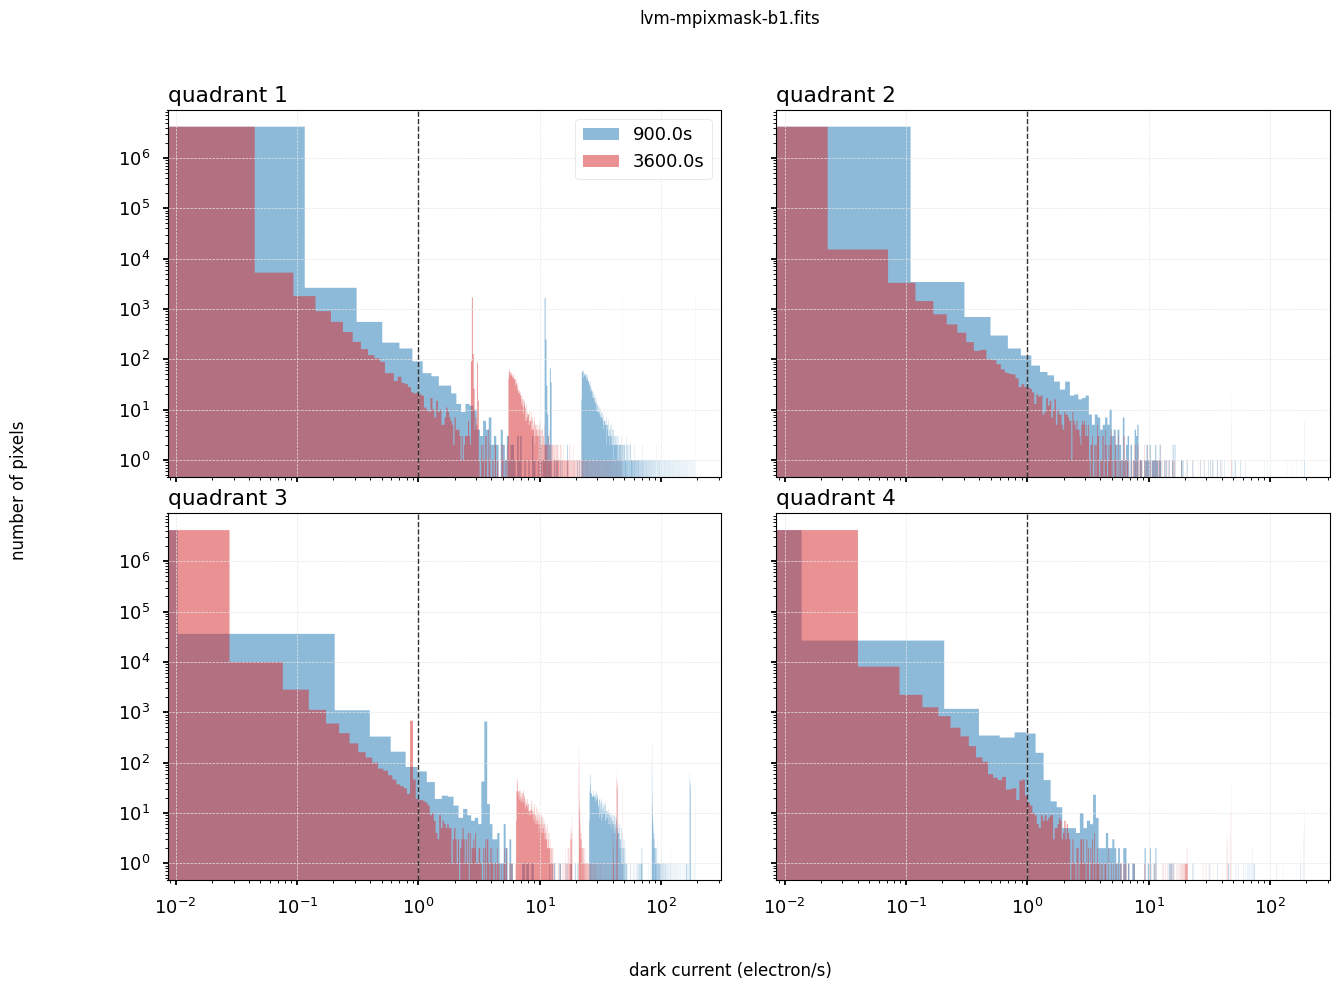

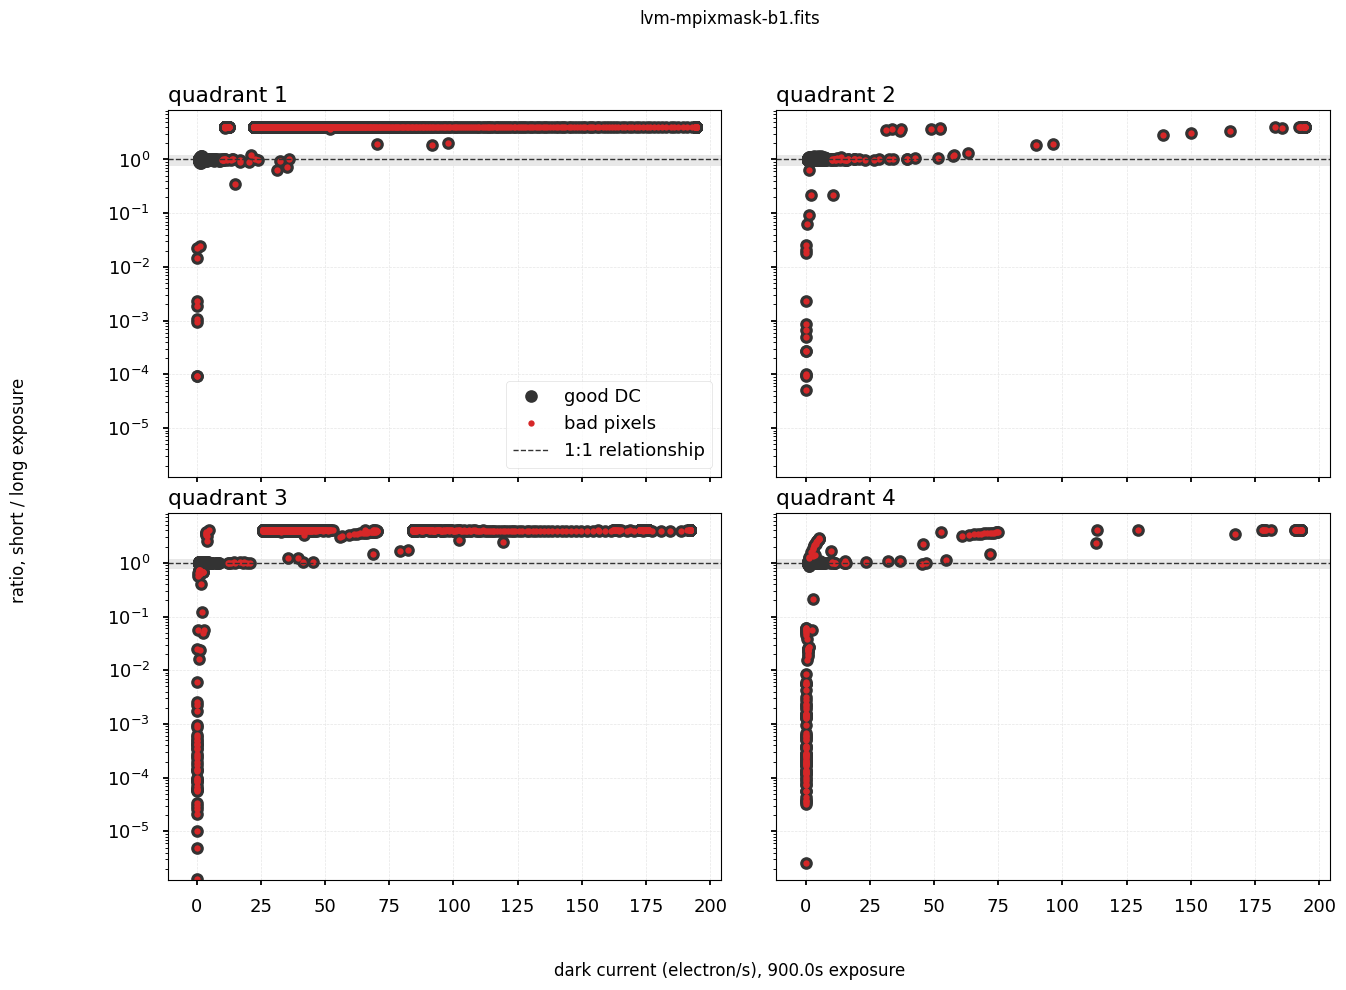

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -5690.08, ratio_max = 29329.54]
[INFO]: plotting flats histograms


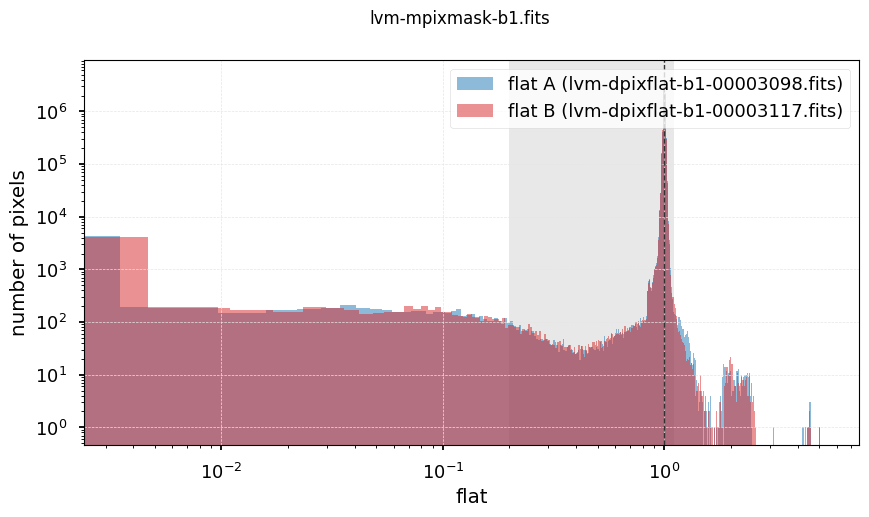

[INFO]: masking 16932 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 26330 pixels in total (0.16%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b1.fits'
[INFO]: loading short dark 'lvm-mdark-b2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b2-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-b2-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 7042 pixels with dark current > 1.0 electron/s
[INFO]: masking 6667 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 816 pixels with dark current > 1.0 electron/s
[INFO]: masking 69 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distrib

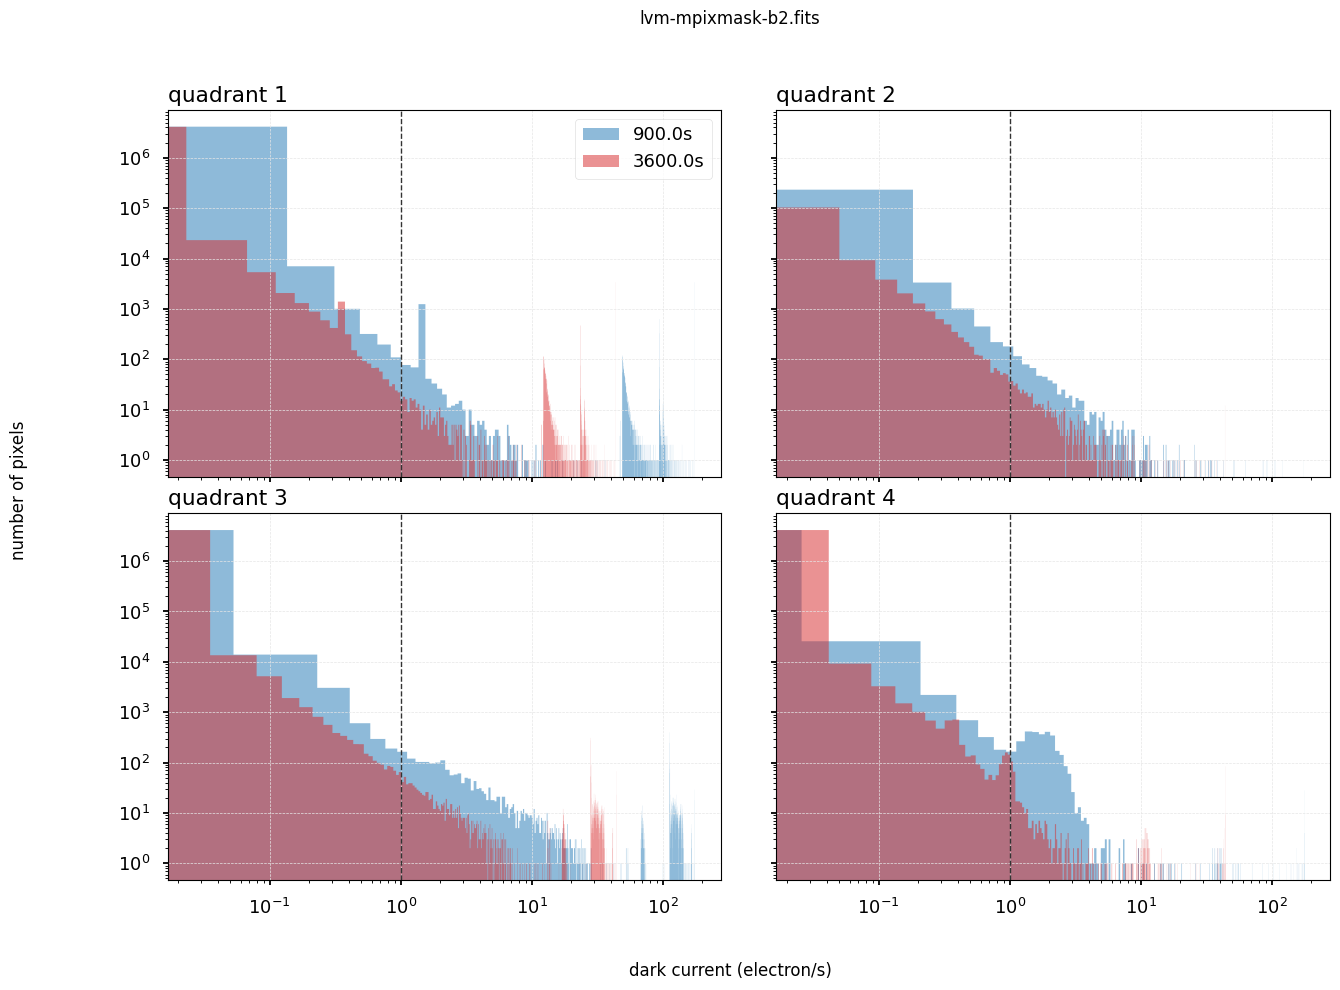

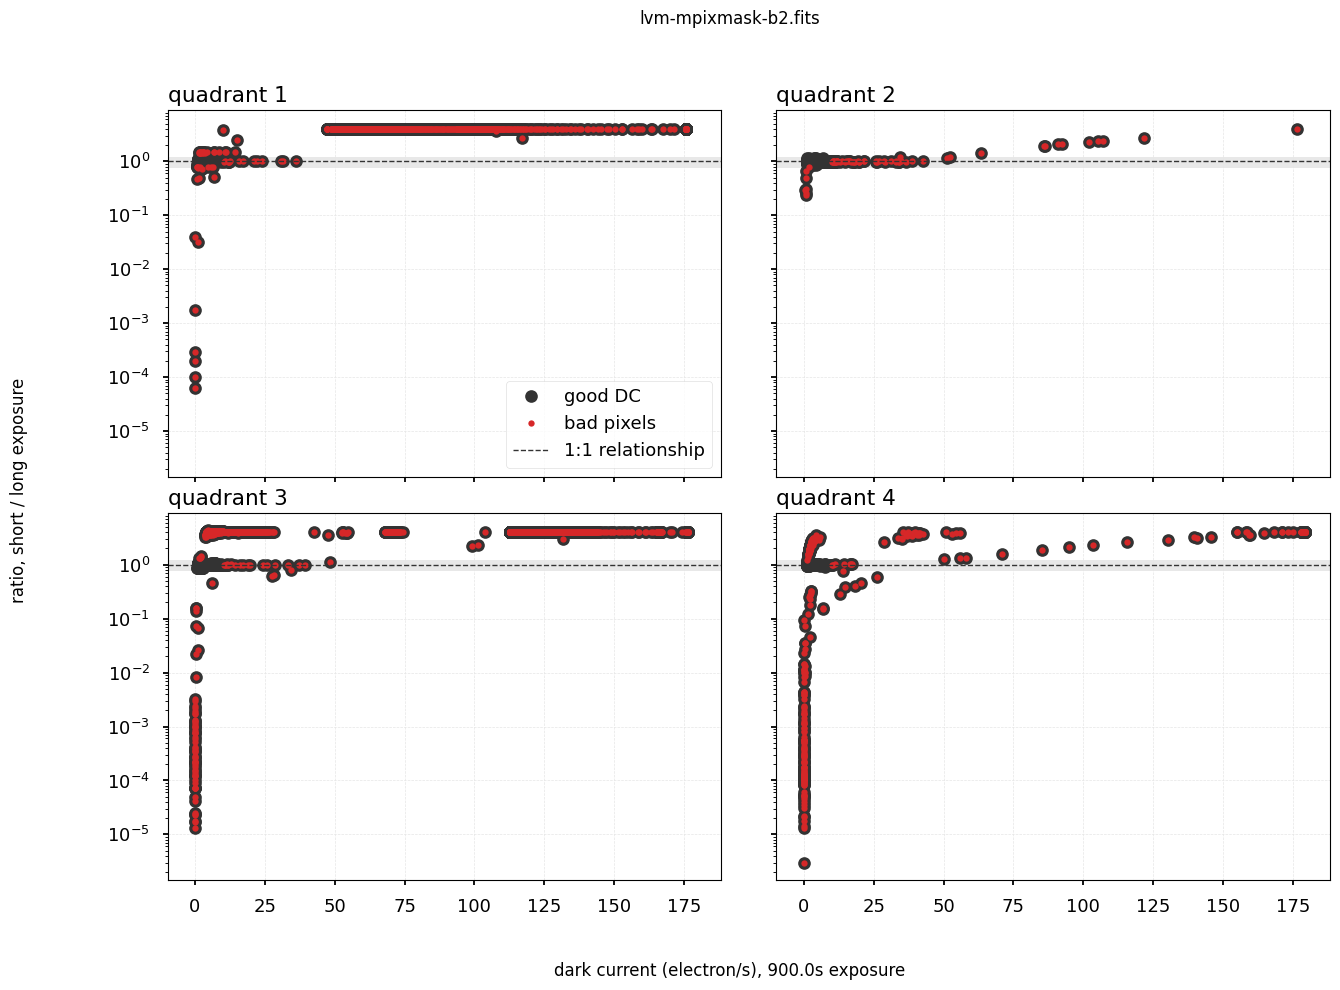

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -14962.64, ratio_max = 43356.37]
[INFO]: plotting flats histograms


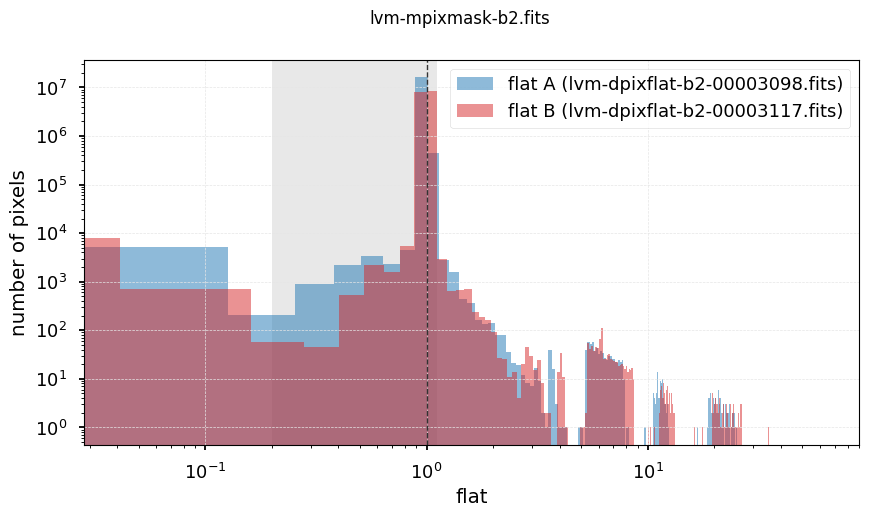

[INFO]: masking 16566 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 27031 pixels in total (0.16%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b2.fits'
[INFO]: loading short dark 'lvm-mdark-b3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b3-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-b3-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 340 pixels with dark current > 1.0 electron/s
[INFO]: masking 22 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 385 pixels with dark current > 1.0 electron/s
[INFO]: masking 20 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distributi

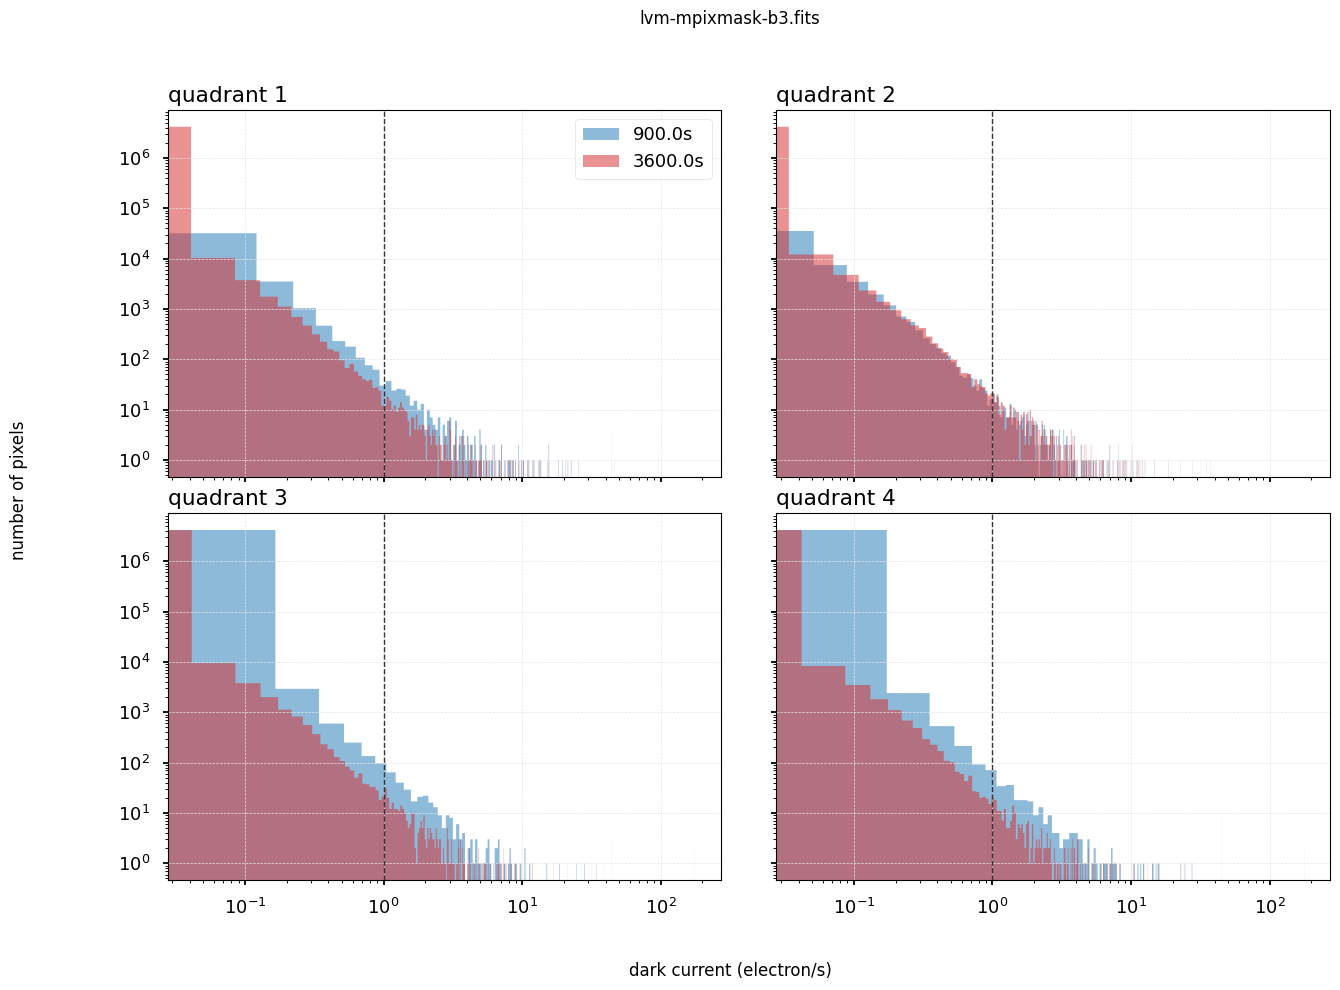

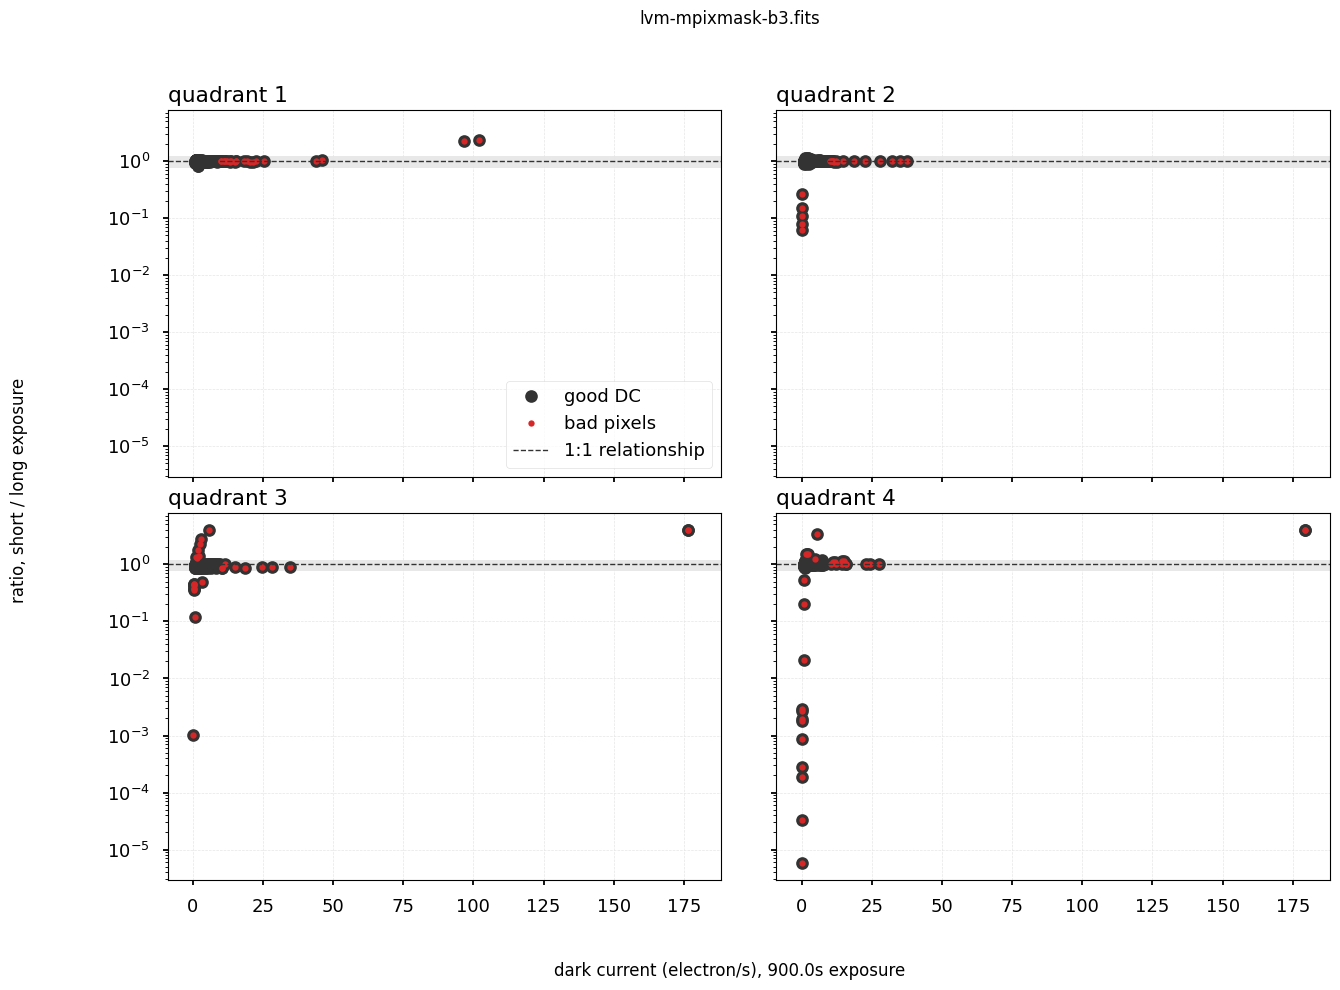

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -160228.89, ratio_max = 9886.92]
[INFO]: plotting flats histograms


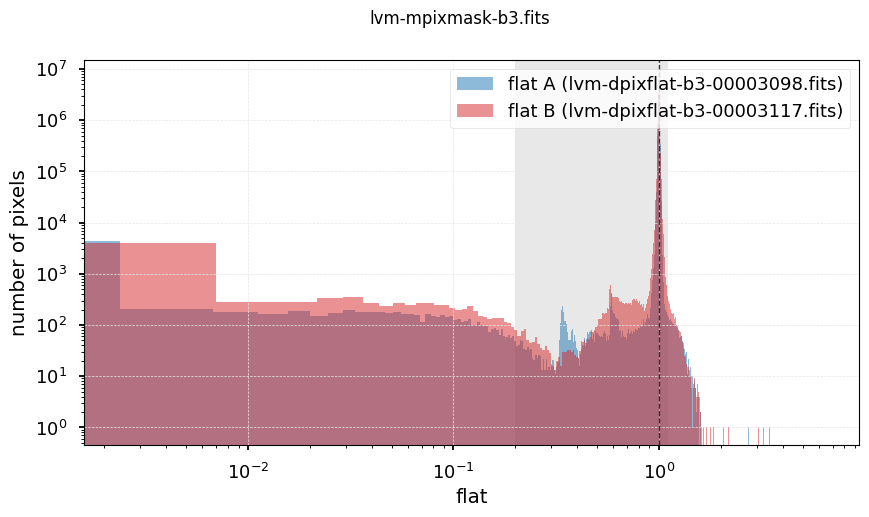

[INFO]: masking 22111 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 22196 pixels in total (0.13%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b3.fits'
[INFO]: loading short dark 'lvm-mdark-r1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r1-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-r1-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 588 pixels with dark current > 1.0 electron/s
[INFO]: masking 376 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 457 pixels with dark current > 1.0 electron/s
[INFO]: masking 188 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribu

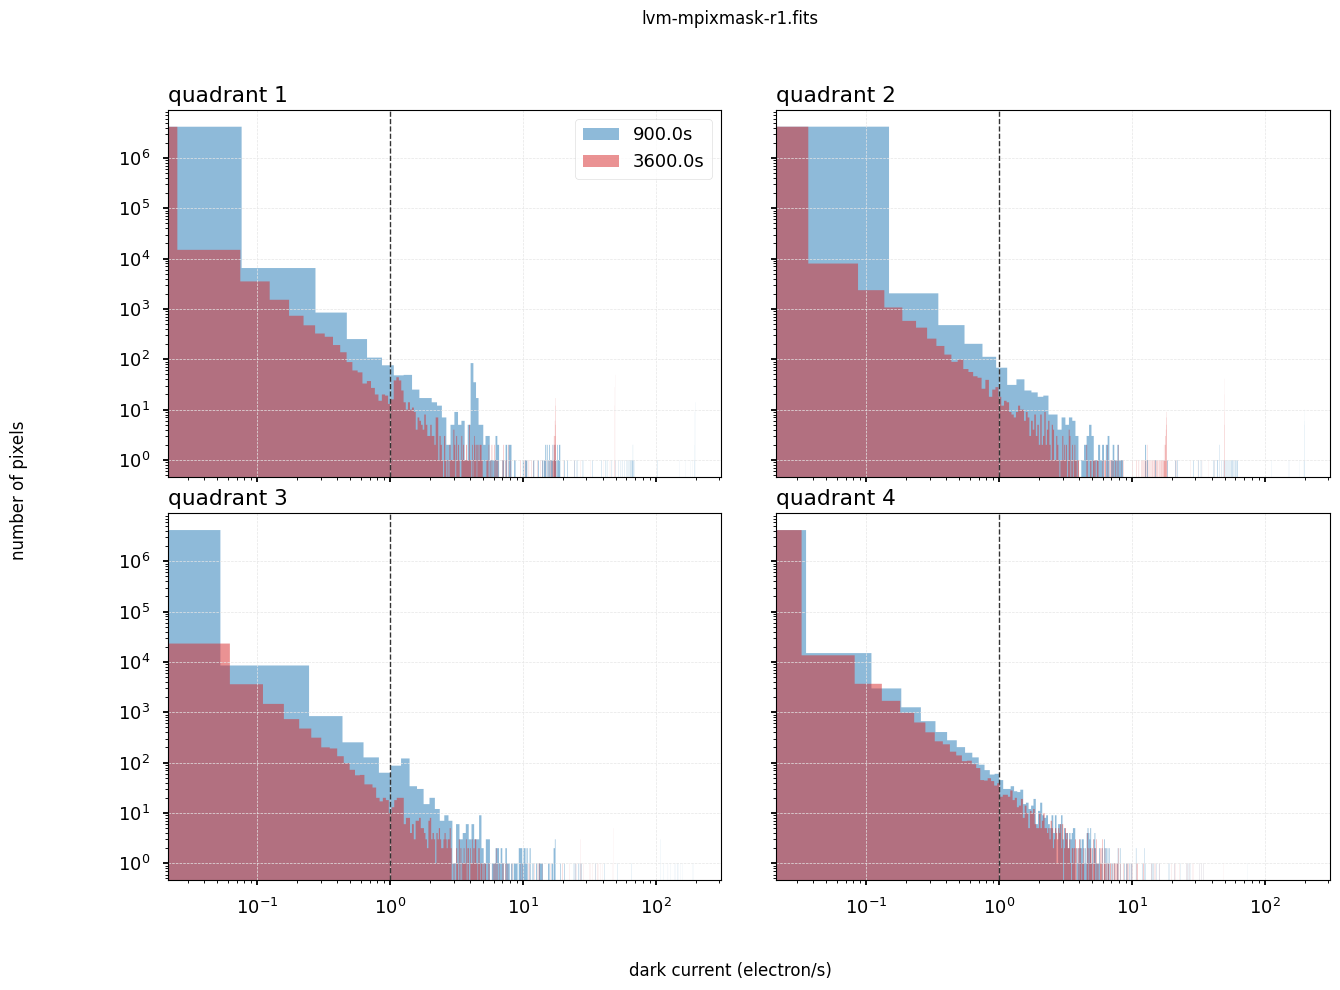

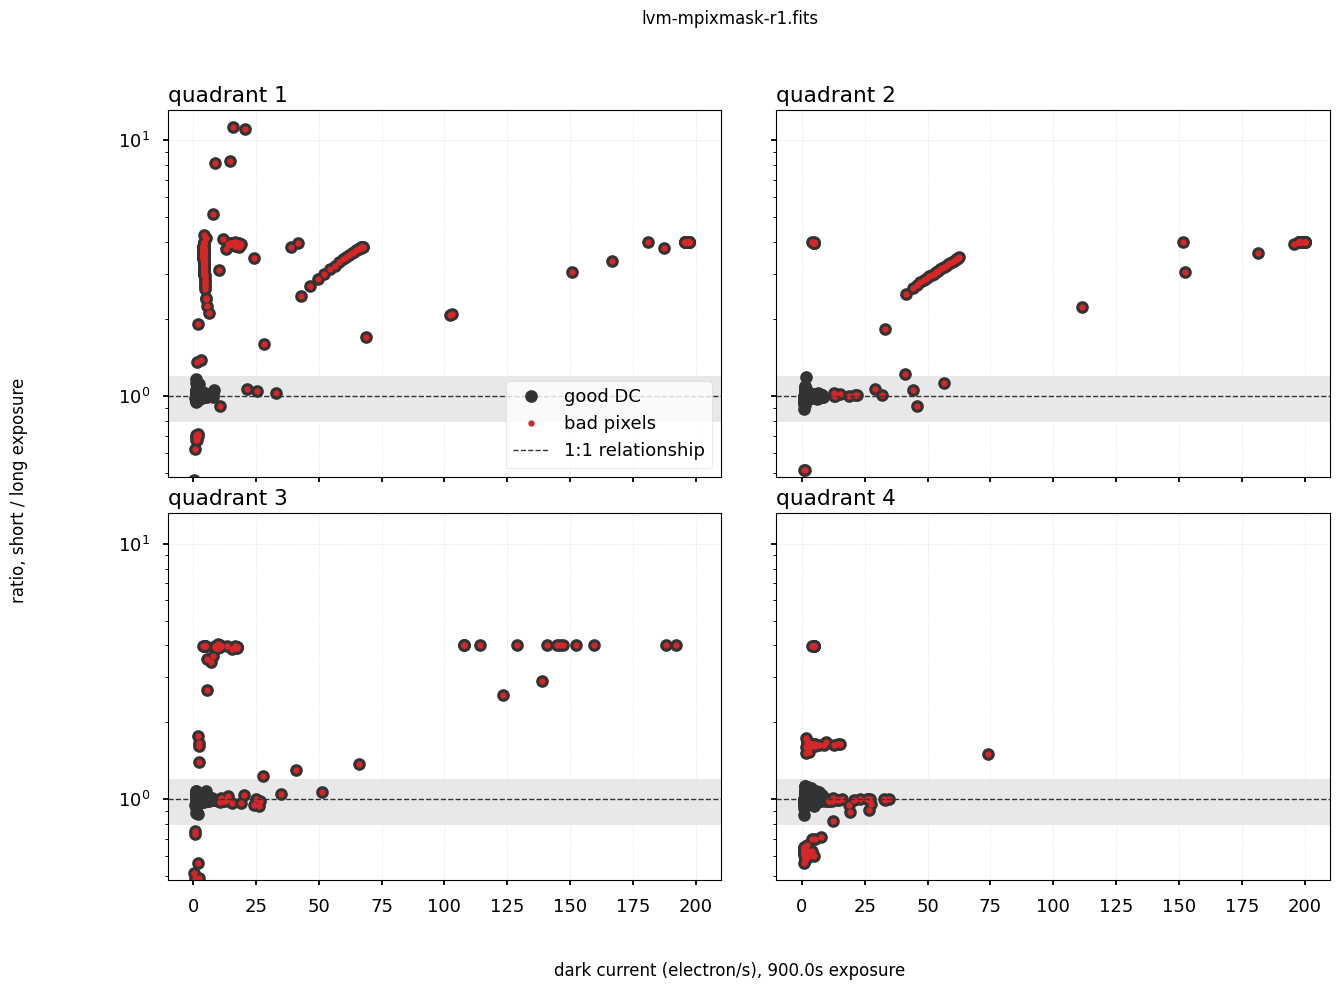

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -2101.68, ratio_max = 309.35]
[INFO]: plotting flats histograms


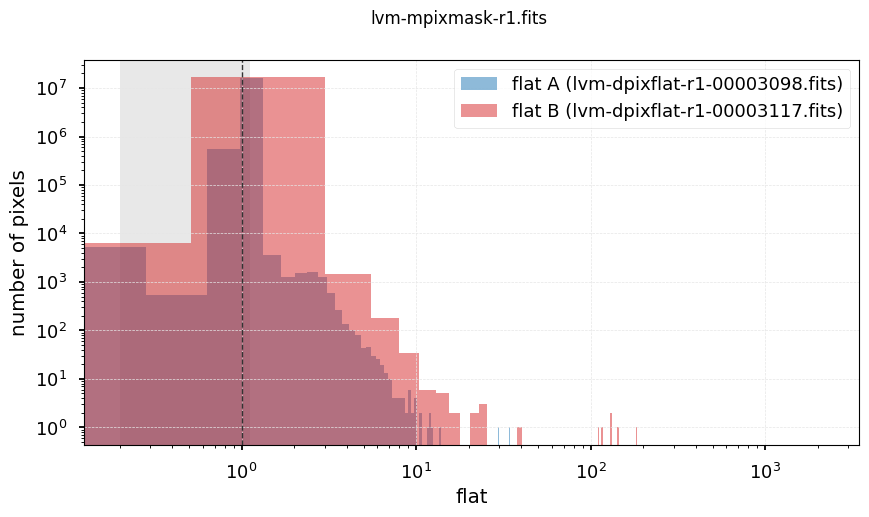

[INFO]: masking 8999 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 9670 pixels in total (0.06%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r1.fits'
[INFO]: loading short dark 'lvm-mdark-r2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r2-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-r2-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 287 pixels with dark current > 1.0 electron/s
[INFO]: masking 36 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 3221 pixels with dark current > 1.0 electron/s
[INFO]: masking 3002 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribut

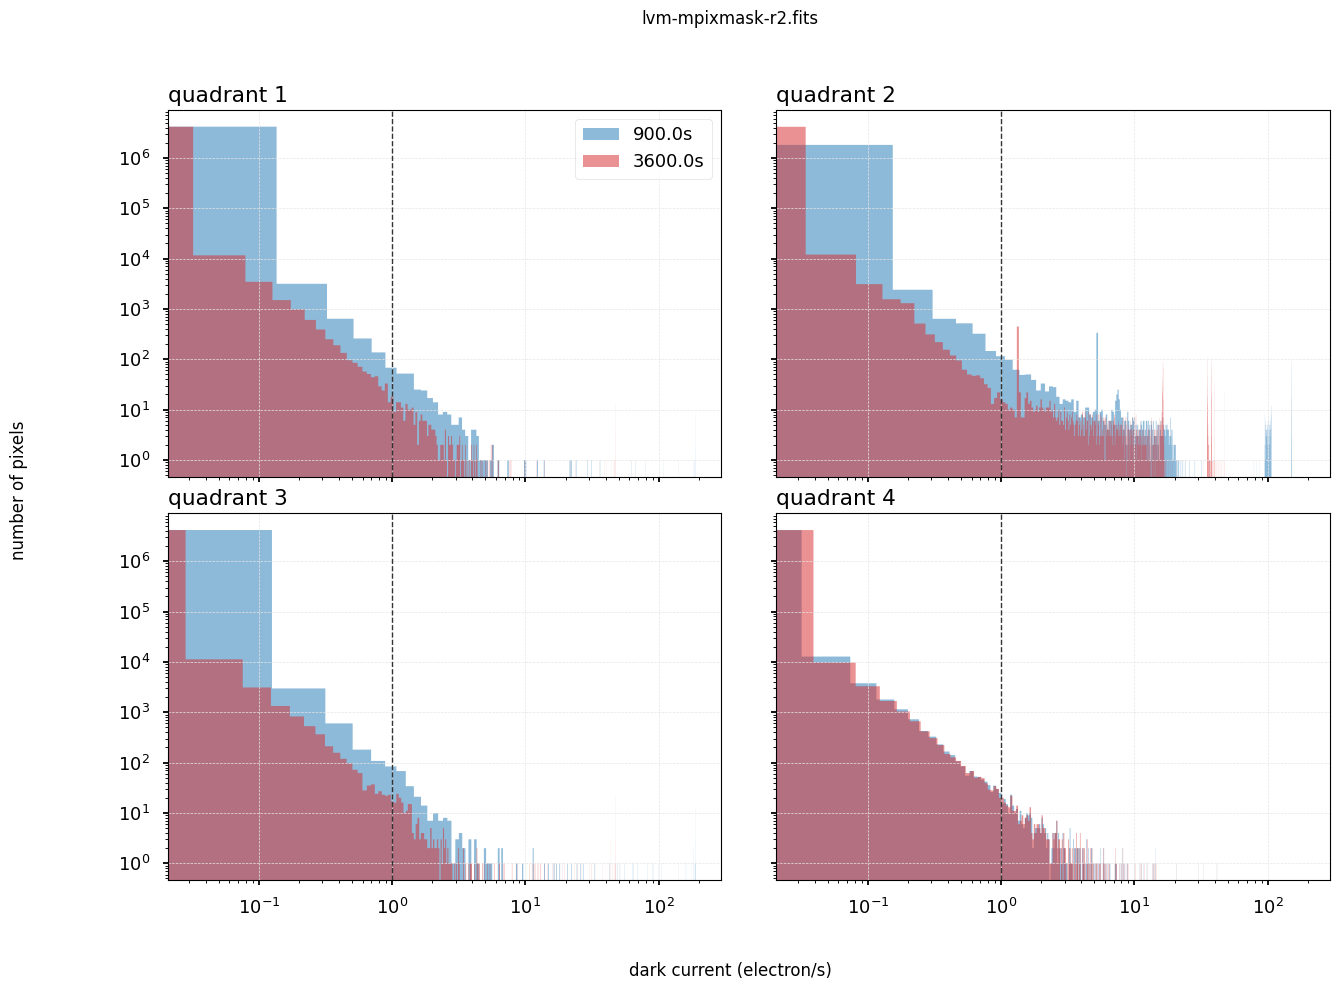

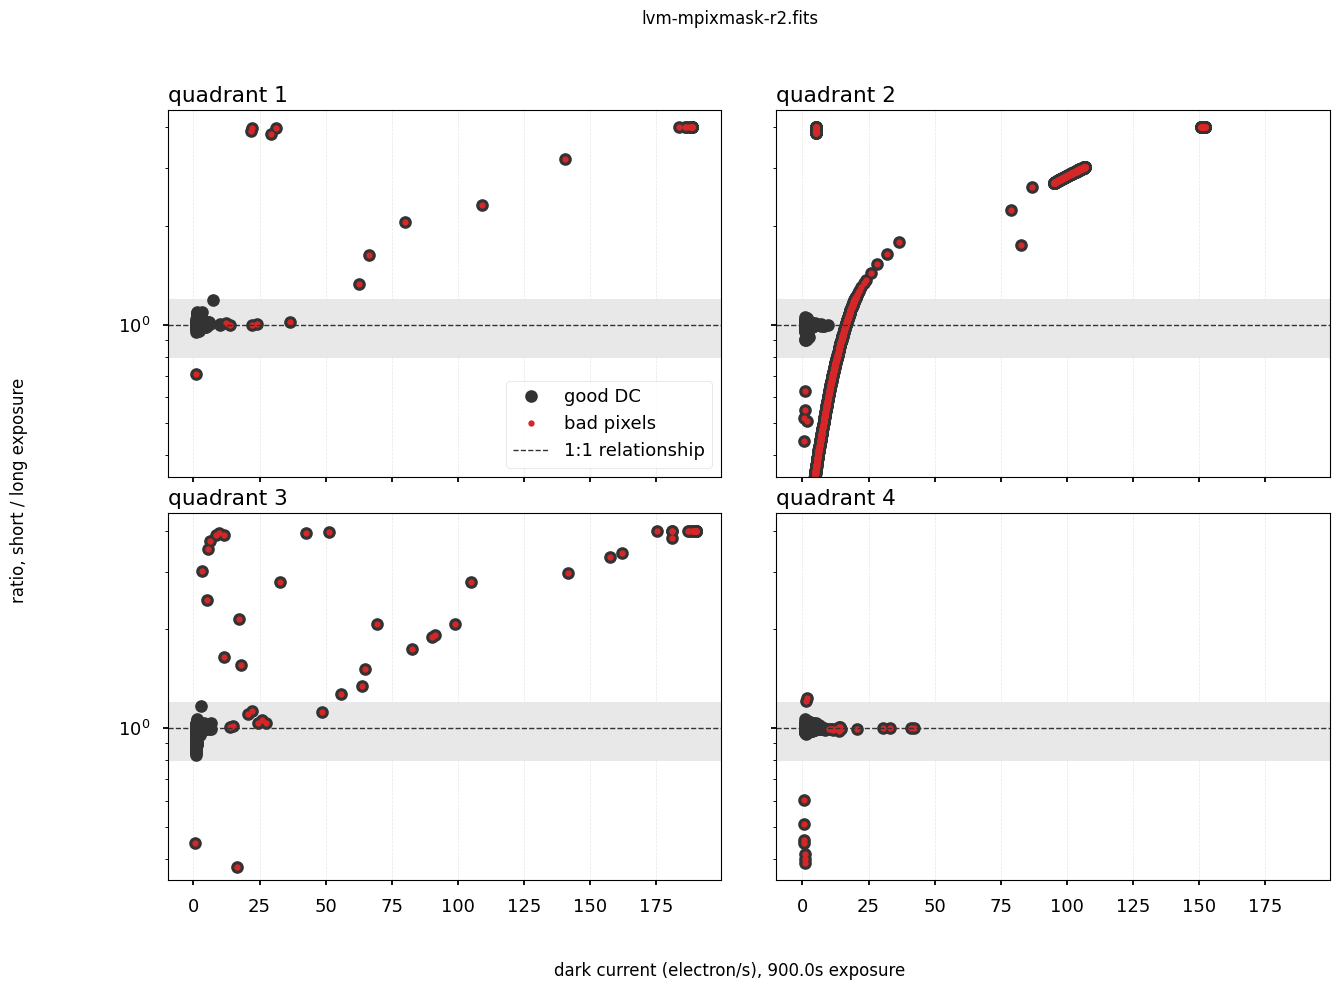

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -7400.43, ratio_max = 4116.11]
[INFO]: plotting flats histograms


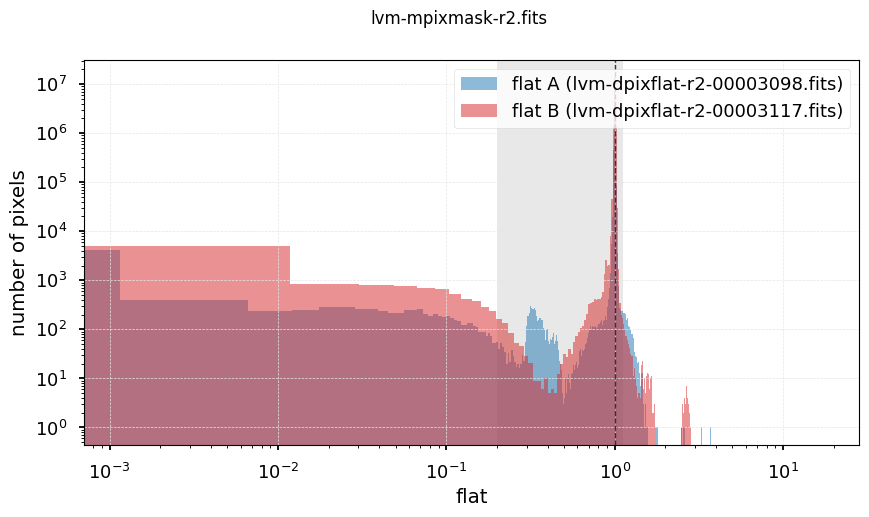

[INFO]: masking 20035 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 23016 pixels in total (0.14%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r2.fits'
[INFO]: loading short dark 'lvm-mdark-r3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r3-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-r3-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 3609 pixels with dark current > 1.0 electron/s
[INFO]: masking 3181 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 630 pixels with dark current > 1.0 electron/s
[INFO]: masking 106 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distri

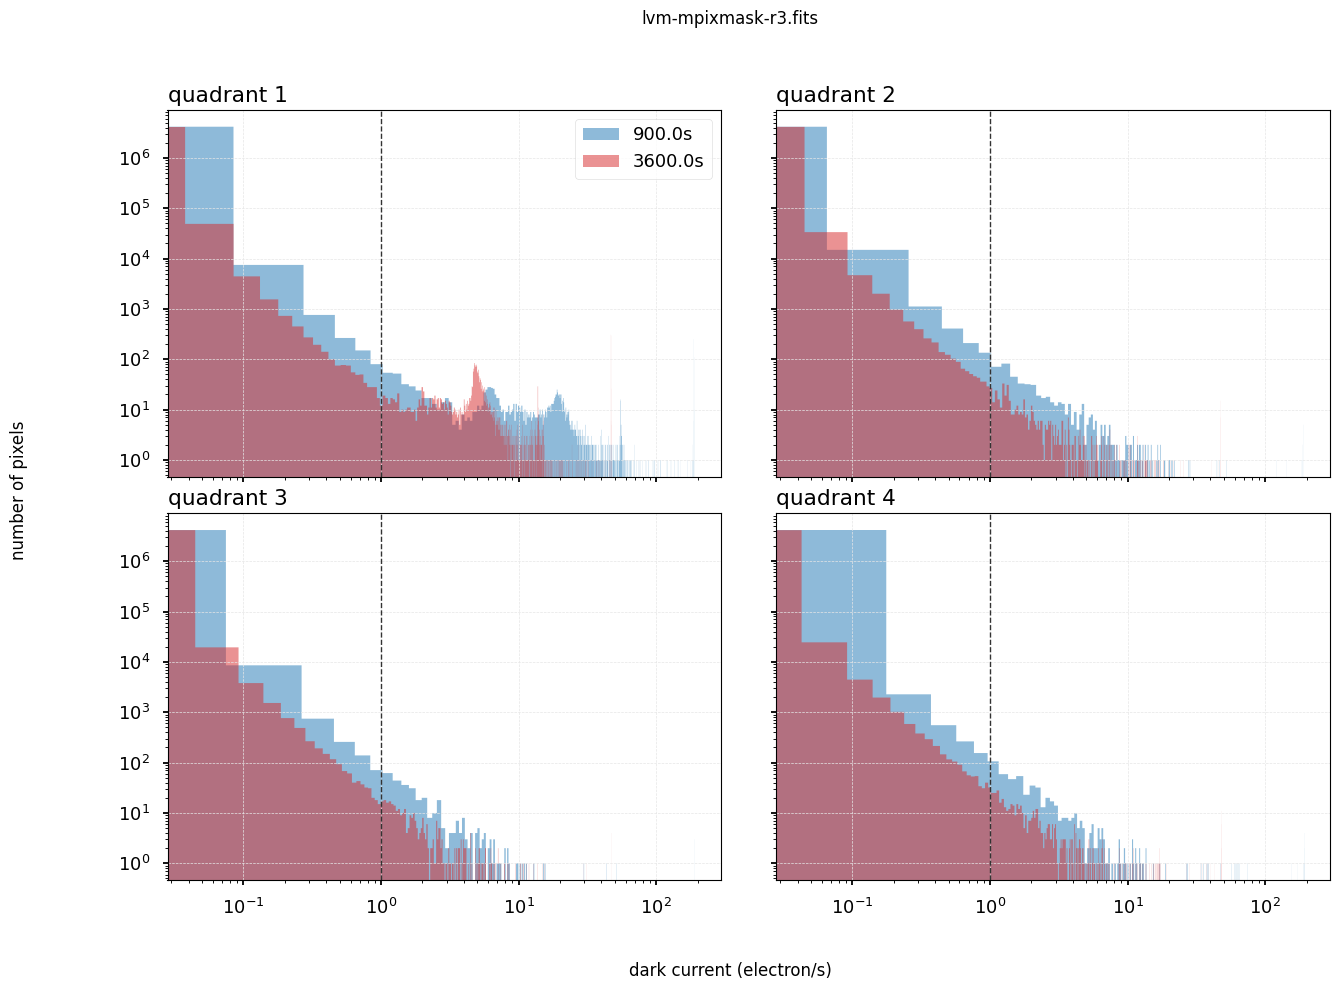

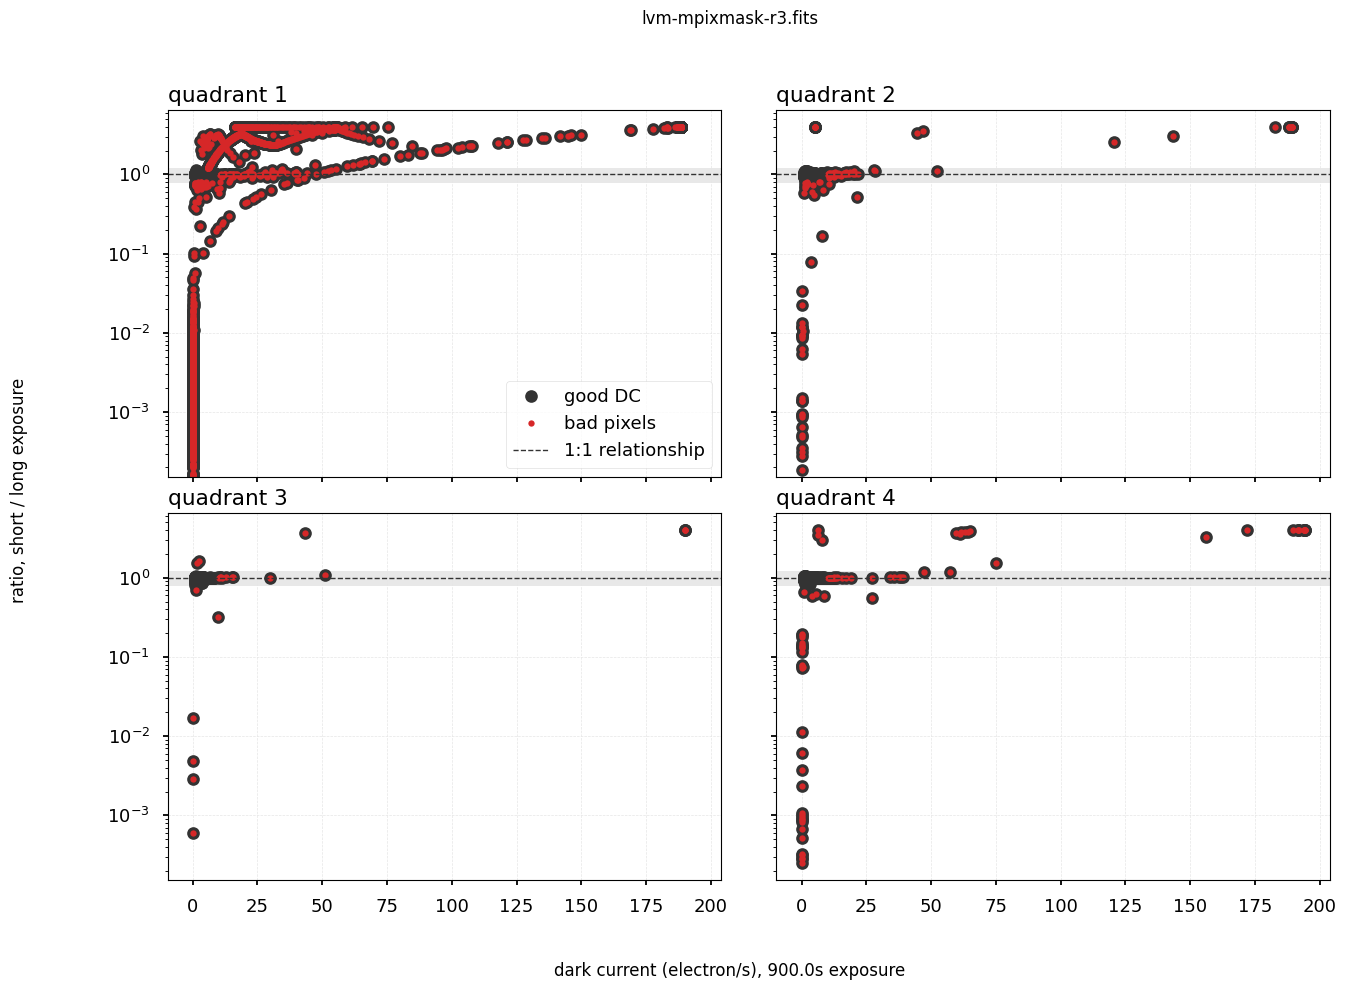

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -2557.25, ratio_max = 21010.31]
[INFO]: plotting flats histograms


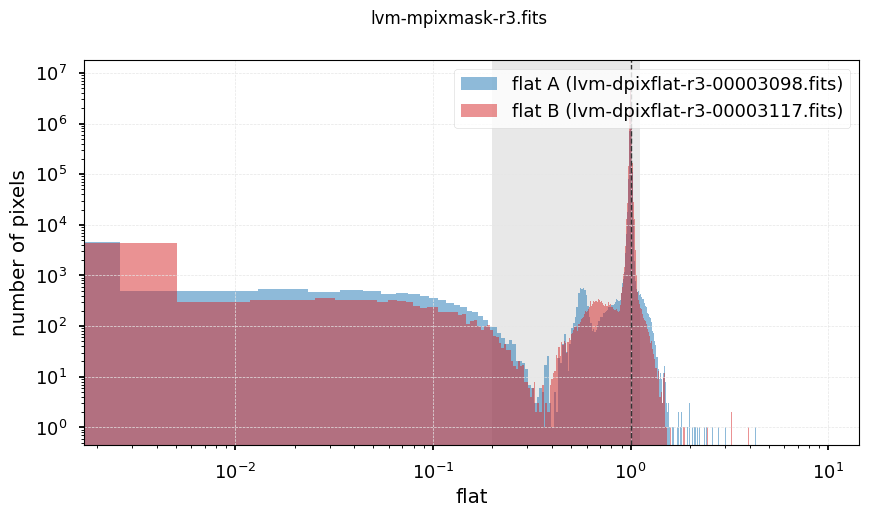

[INFO]: masking 21768 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 25116 pixels in total (0.15%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r3.fits'
[INFO]: loading short dark 'lvm-mdark-z1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z1-00003098.fits'
[INFO]: loading flat B 'lvm-dpixflat-z1-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 5813 pixels with dark current > 1.0 electron/s
[INFO]: masking 1084 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 227 pixels with dark current > 1.0 electron/s
[INFO]: masking 5 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribu

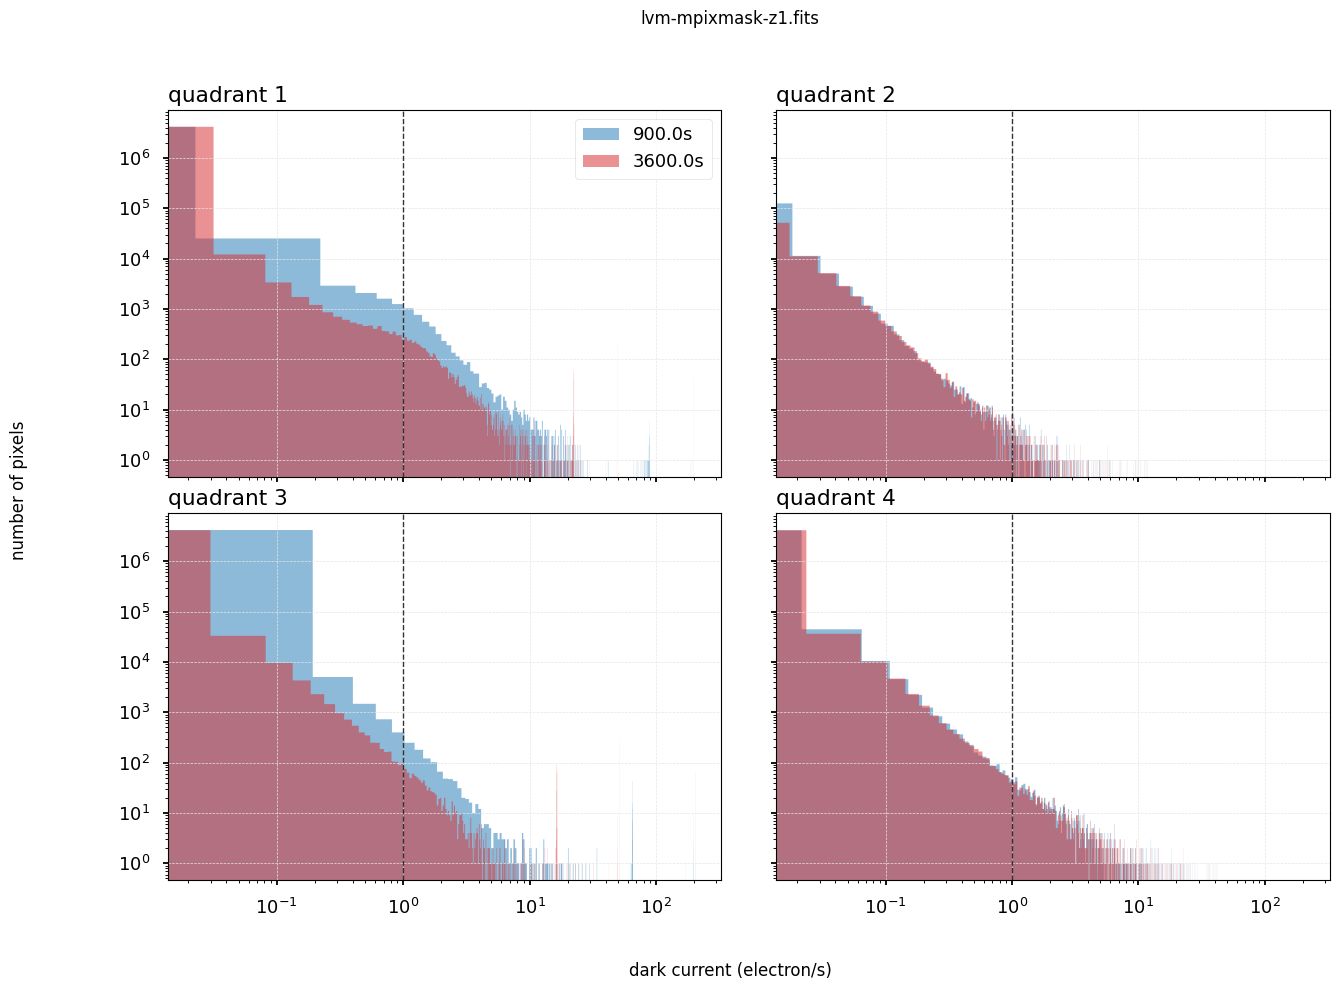

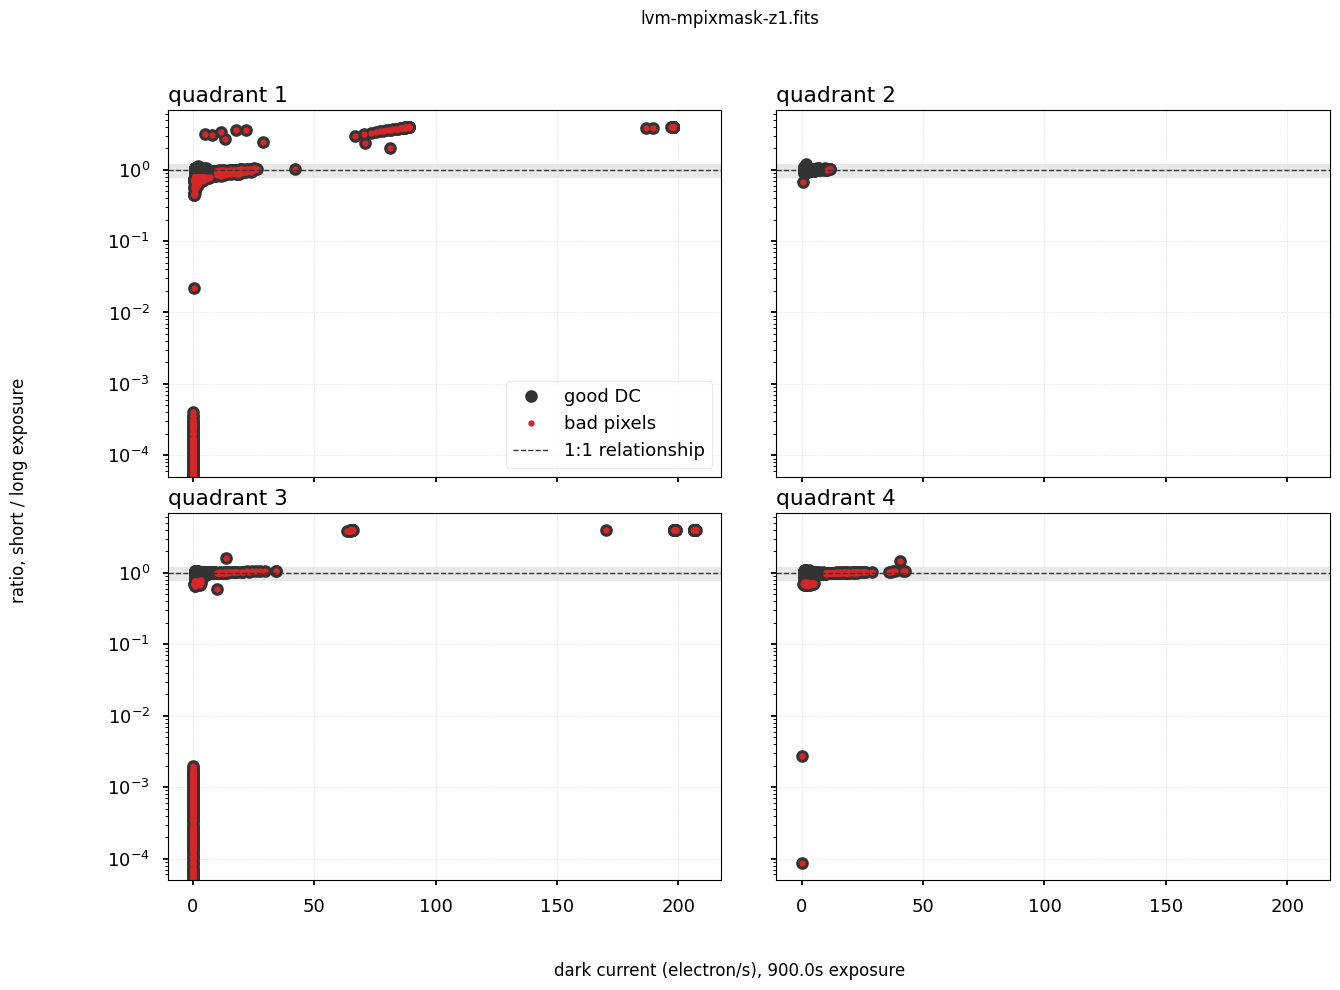

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -12183.32, ratio_max = 10183.42]
[INFO]: plotting flats histograms


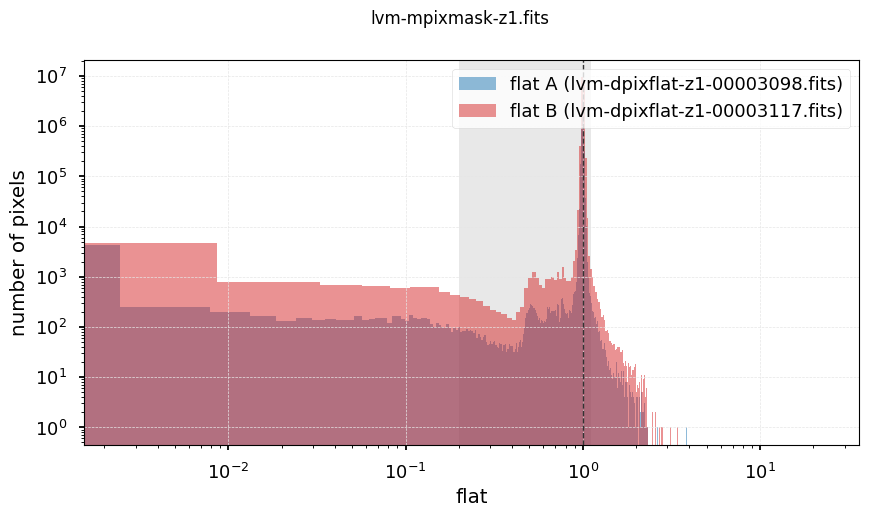

[INFO]: masking 17338 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 19042 pixels in total (0.11%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z1.fits'
[INFO]: loading short dark 'lvm-mdark-z2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z2-00003107.fits'
[INFO]: loading flat B 'lvm-dpixflat-z2-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 398 pixels with dark current > 1.0 electron/s
[INFO]: masking 67 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 4477 pixels with dark current > 1.0 electron/s
[INFO]: masking 4327 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distrib

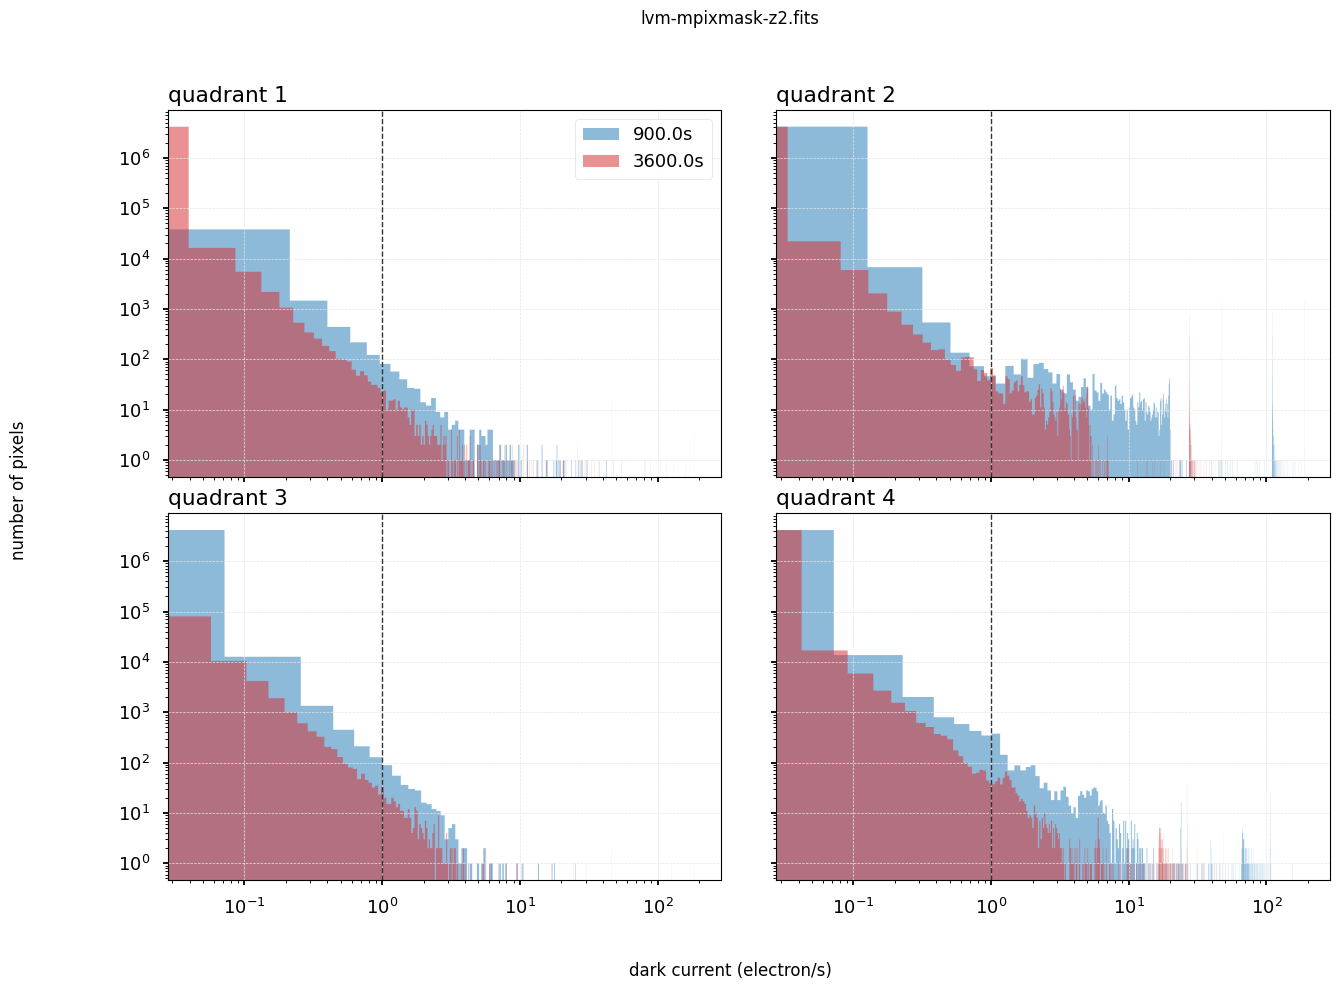

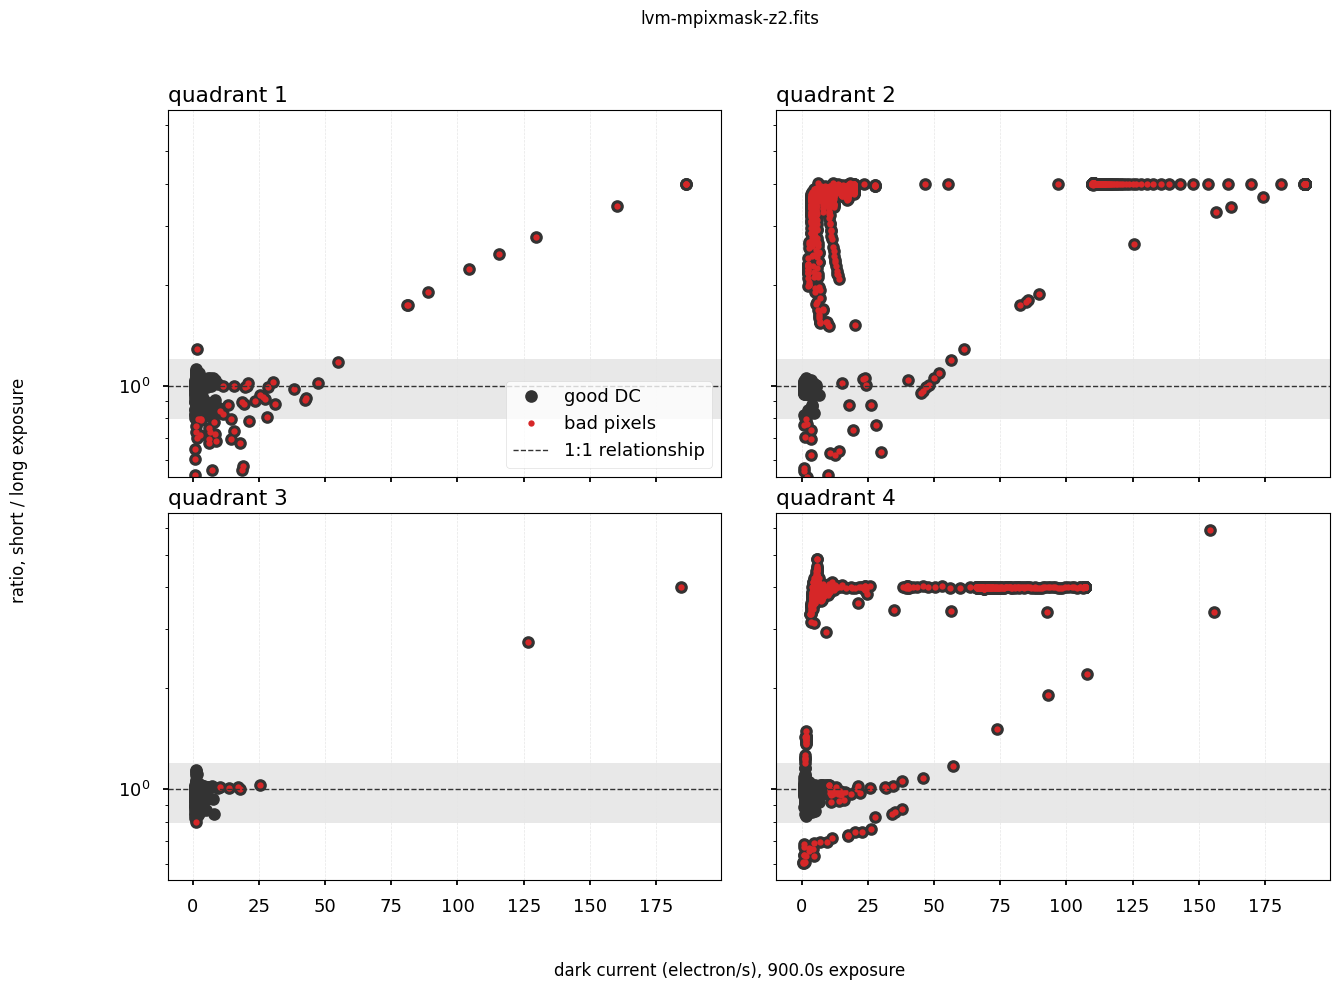

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -2494.91, ratio_max = 6041.85]
[INFO]: plotting flats histograms


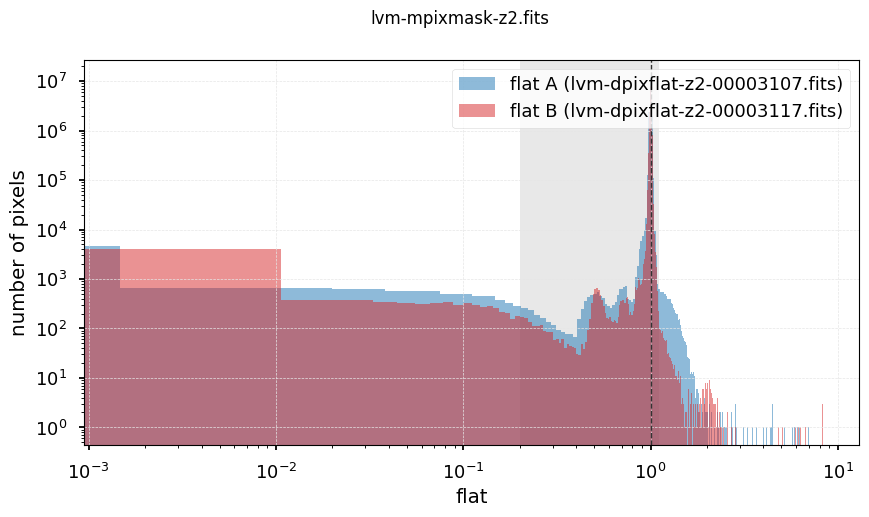

[INFO]: masking 24337 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 29432 pixels in total (0.18%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z2.fits'
[INFO]: loading short dark 'lvm-mdark-z3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z3-00003107.fits'
[INFO]: loading flat B 'lvm-dpixflat-z3-00003117.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 393 pixels with dark current > 1.0 electron/s
[INFO]: masking 58 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 123 pixels with dark current > 1.0 electron/s
[INFO]: masking 13 pixels with DC ratio < 0.8 or > 1.2
[INFO]: plotting count distributi

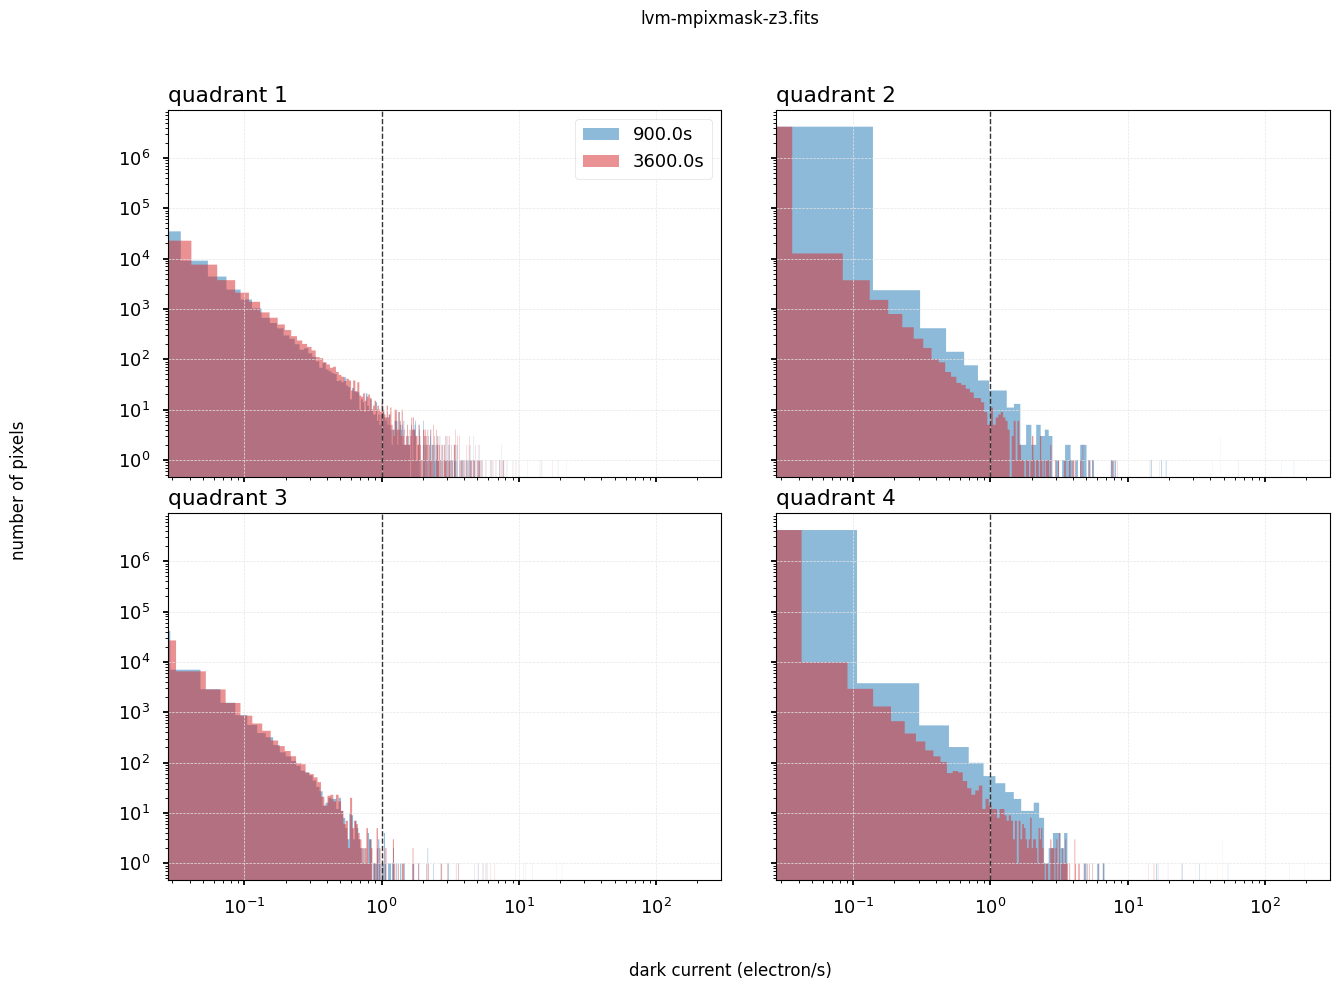

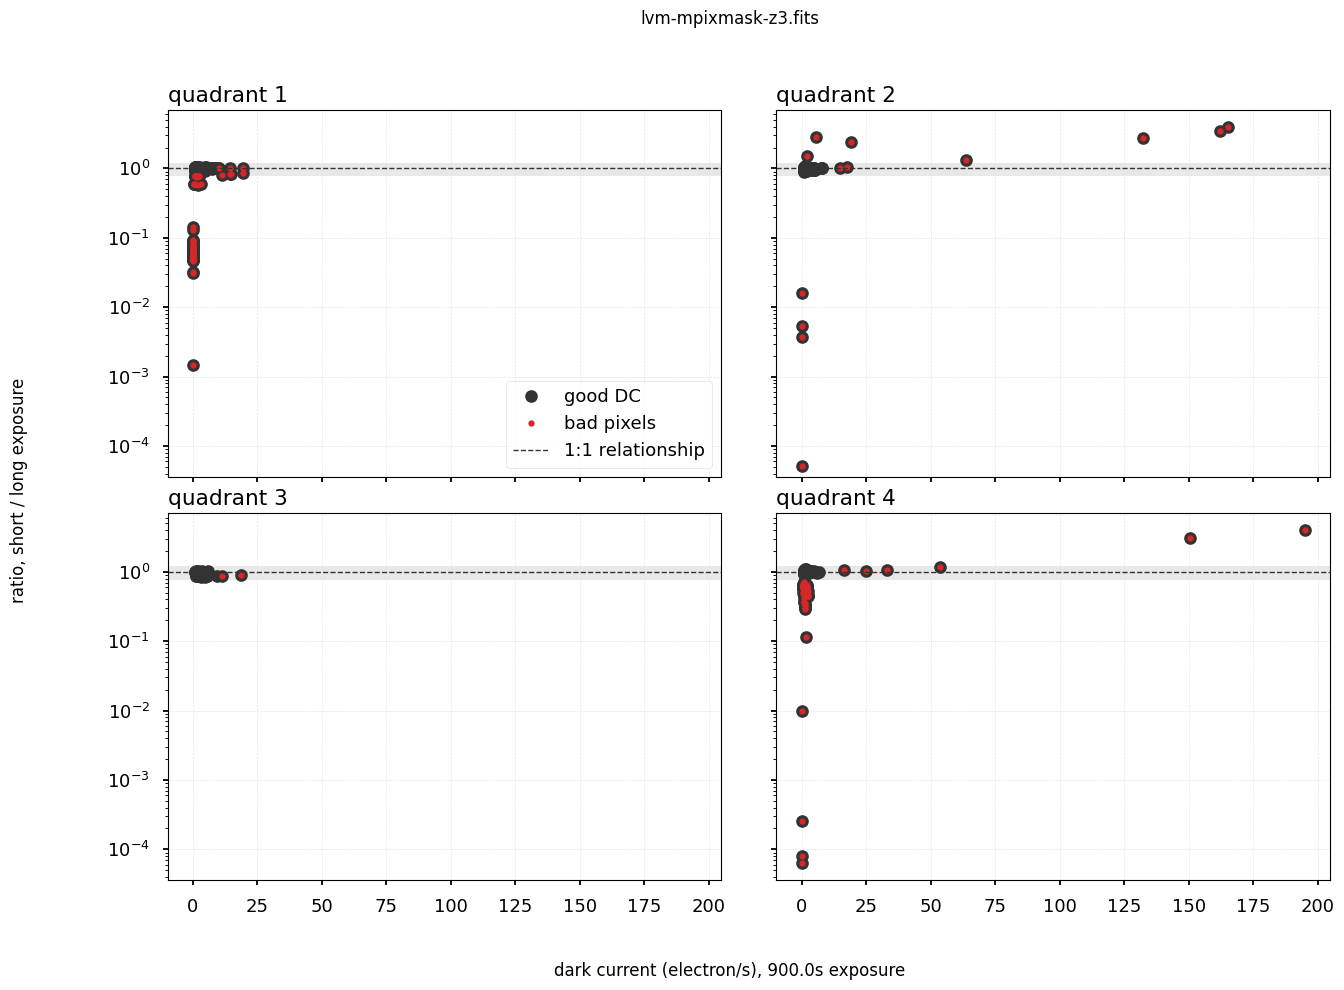

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -5342.38, ratio_max = 5647.54]
[INFO]: plotting flats histograms


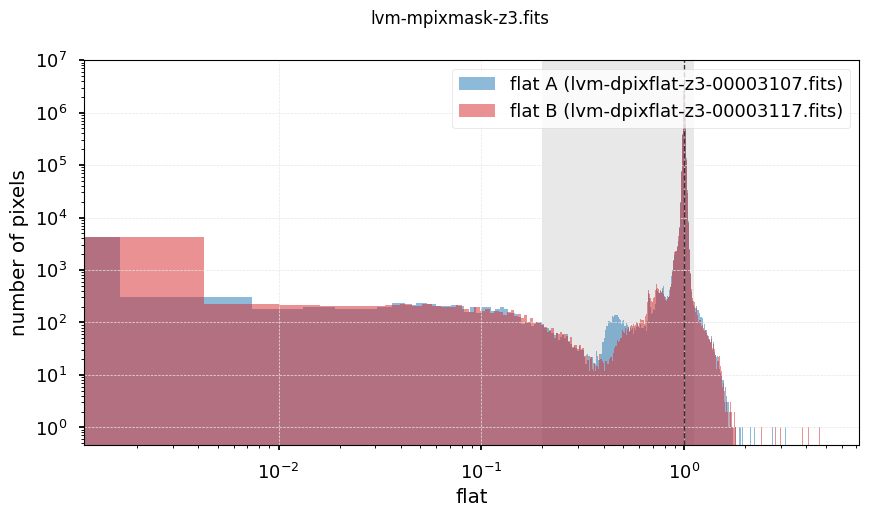

[INFO]: masking 16834 pixels with flats ratio < 0.2 or > 1.1
[INFO]: masked 17011 pixels in total (0.10%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z3.fits'


In [8]:
dflat_paths = sorted([os.path.join(target_dir, dflat) for dflat in os.listdir(target_dir) if "dpixflat" in dflat])
dflat_groups = groupby(dflat_paths, key=lambda s: os.path.basename(s).split("-")[2])


for camera, group in dflat_groups:
    medians = []
    group = list(group)
    # compute medians of all detrended pixel flats
    for dflat_path in group:
        medians.append(np.nanmedian(imageMethod.loadImage(dflat_path)._data))

    # sort paths by median values
    idx = np.argsort(medians)
    dflat_group = np.asarray(group)[idx]

    # pick two most different pixelflats
    flat_a = dflat_group[0]
    flat_b = dflat_group[-1]
    
    pixmask = imageMethod.create_pixelmask(in_short_dark=os.path.join(target_dir, f"lvm-mdark-{camera}-{short_exptime}s.fits"),
                                           in_long_dark=os.path.join(target_dir, f"lvm-mdark-{camera}-{long_exptime}s.fits"),
                                           in_flat_a=flat_a, in_flat_b=flat_b,
                                           out_pixmask=os.path.join(target_dir, f"lvm-mpixmask-{camera}.fits"), display_plots=True)